# Final Project Report: Analysis of COVID cases in Ontario, CA
Owned by Asghar Sadeghi, PhD, Dec. 2020

## Week 5 - Part A: Statement of the Problem

In this study, we plan to analyze the COVID-19 cases in Ontario province. Currently, we observe the second wave of pandemic and the government plans to impose additional restrictions on different counties. Given the venues in the neighborhood of a medical center and the number of confirmed cases, we try to cluster similar cities/counties in terms of COVID behaviour and consult the government to make decisions accordingly.
In the first section we analyze the data, then we try to map it, later the neighborhoud venues will be extraced using FourSquare, and as the final step the data will be clustered to 5 different categories to restrict the interactions.
The first audience of this study would be the Government of Ontario and the Mayers and City councils, but the citizens also could be the second audience.

### Import libraries

In [1]:
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#!conda install -c anaconda beautifulsoup4 --yes
from bs4 import BeautifulSoup

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

# we are using the inline backend
%matplotlib inline 
import matplotlib as mpl
import matplotlib.pyplot as plt
import datetime

import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import seaborn as sns

# Handle date time conversions between pandas and matplotlib
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Use white grid plot background from seaborn
sns.set(font_scale=1.5, style="whitegrid")

%matplotlib inline
import matplotlib
matplotlib.style.use('ggplot')

print('Libraries imported. - Confirmed')

#This is how to generate pdf file of each notebook:
    #jupyter nbconvert --to html --TemplateExporter.exclude_input=True  PR_Assign_W5.ipynb
    #jupyter nbconvert --to pdf --TemplateExporter.exclude_input=True  PR_Assign_W5.ipynb

Libraries imported. - Confirmed


## Week 5 - Part B: Data Section
The data is live COVID data that is being posted on the "https://data.ontario.ca". It includes all reported cases since the start of pandemic.
The columns for each case are the exact episode date, age grouped by decade, gender, outcome (recovered, active, and death), Reporting PHU ID, name, postal code, latitude and longitude.
Furthermore, using the Foursquare website, the venues near each public health unit (PHU) is extracted to find a relation between venues and the number of confirmed cases.
Data URL: https://data.ontario.ca/dataset/f4112442-bdc8-45d2-be3c-12efae72fb27/resource/455fd63b-603d-4608-8216-7d8647f43350/download/conposcovidloc.csv

In [2]:
links={'COVID_Cases_Ontario':'https://data.ontario.ca/dataset/f4112442-bdc8-45d2-be3c-12efae72fb27/resource/455fd63b-603d-4608-8216-7d8647f43350/download/conposcovidloc.csv'}

In [3]:
csv_path = links["COVID_Cases_Ontario"]
df_covid = pd.read_csv(csv_path)
df_covid.drop(['Case_Reported_Date', 'Test_Reported_Date', 'Specimen_Date', 'Case_AcquisitionInfo', 'Outbreak_Related', 'Reporting_PHU_ID','Reporting_PHU_Address','Reporting_PHU_City','Reporting_PHU_Website'], axis=1, inplace=True)

## Week 5 - Part C: Basic analysis of the received data
In the first step, we drop the cases that include 'NaN' values in their cells. Data shows handful of cases at the start of pandemic have less information, but as times go on, the information package is more complete.

In [4]:
df_covid['Age_Group'].replace('UNKNOWN', np.nan)
df_covid.dropna(axis=0, how='any', thresh=None, subset=None, inplace=True)
print ('After cleaning, number of confirmed cases to be analyzed in the rest of study are:', df_covid.shape[0])

After cleaning, number of confirmed cases to be analyzed in the rest of study are: 121733


A summary of data is shown in Table 1. Dataframe includes more columns, but for the sake of brevity, we just show some of the main columns.

Table 1: Daily COVID-19 Cases, Ontario Province

In [5]:
df_covid['Accurate_Episode_Date'] = pd.to_datetime(df_covid['Accurate_Episode_Date'])
df_covid[['Accurate_Episode_Date','Age_Group','Client_Gender','Reporting_PHU']].head()

,Accurate_Episode_Date,Age_Group,Client_Gender,Reporting_PHU
0,2020-11-03,60s,MALE,Peel Public Health
1,2020-11-23,30s,FEMALE,York Region Public Health Services
2,2020-11-26,40s,FEMALE,Durham Region Health Department
3,2020-11-19,70s,FEMALE,Peel Public Health
4,2020-11-20,30s,MALE,Peel Public Health


Now, data is grouped on a weekly basis for a better representation on plot. The onjective here is to see the confirmed cases per week and observe the trend of confirmed cases.

Table 2: Confirmed cases on a weekly basis

In [6]:
per = df_covid.Accurate_Episode_Date.dt.to_period("W")  # new way to get the same
g_weekly_tot = df_covid[['Row_ID']].groupby(per).count()
g_weekly_tot.head()

,Row_ID
Accurate_Episode_Date,
2019-12-23/2019-12-29,2
2019-12-30/2020-01-05,2
2020-01-06/2020-01-12,1
2020-01-13/2020-01-19,1
2020-01-20/2020-01-26,3


Confirmed cases are divided based on the gender to see the significance of each gender exposure to virus.

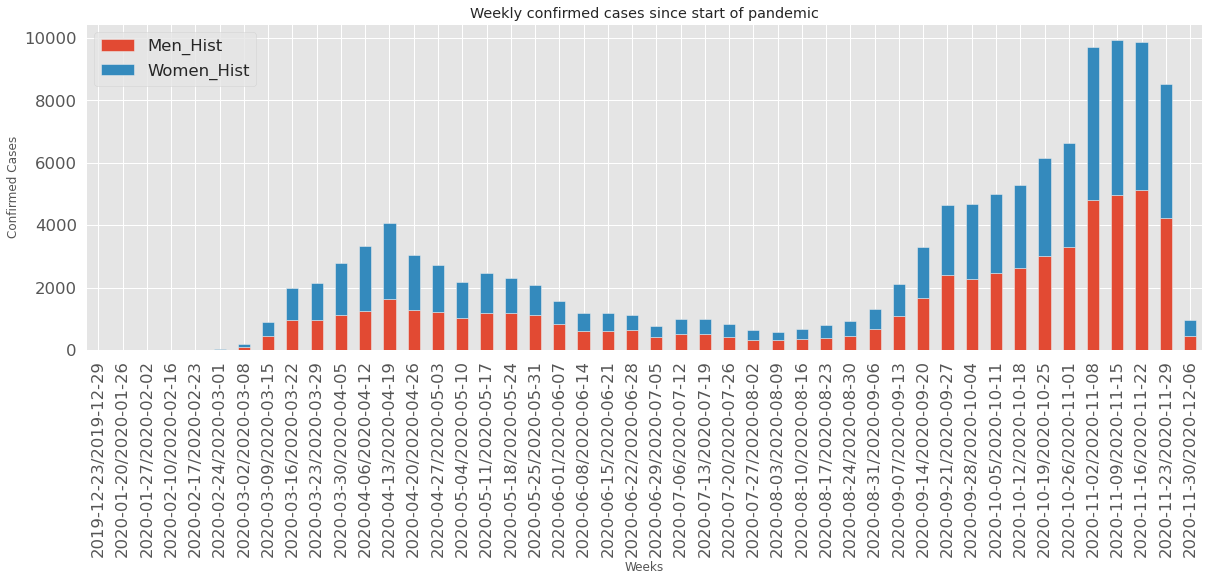

In [7]:
per = df_covid.Accurate_Episode_Date.dt.to_period("W")  # new way to get the same
g_weekly_men = df_covid[df_covid['Client_Gender']=='MALE'].groupby(per).count()

per = df_covid.Accurate_Episode_Date.dt.to_period("W")  # new way to get the same
g_weekly_women = df_covid[df_covid['Client_Gender']=='FEMALE'].groupby(per).count()

plotdata = pd.merge(g_weekly_men['Row_ID'],g_weekly_women['Row_ID'],on='Accurate_Episode_Date')
plotdata.rename(columns={'Row_ID_x': 'Men_Hist', 'Row_ID_y': 'Women_Hist'}, index={'Accurate_Episode_Date': 'Weeks_Since_Pandemic'}, inplace=True)

plotdata.plot(kind='bar', stacked=True, figsize=(20, 6), rot=90) # rotate the bars by 90 degrees

plt.xlabel('Weeks')
plt.ylabel('Confirmed Cases')
plt.title('Weekly confirmed cases since start of pandemic')

plt.show()

Figure 1: Weekly visualization of confirmed cases based on gender

Figure 1 shows that we are exactly in the middle of second wave. The pandemic trend graphically seems to be identical for each gender. In the next plot, we like to see how the trend of fatality has changed in the second wave compared to the first one.

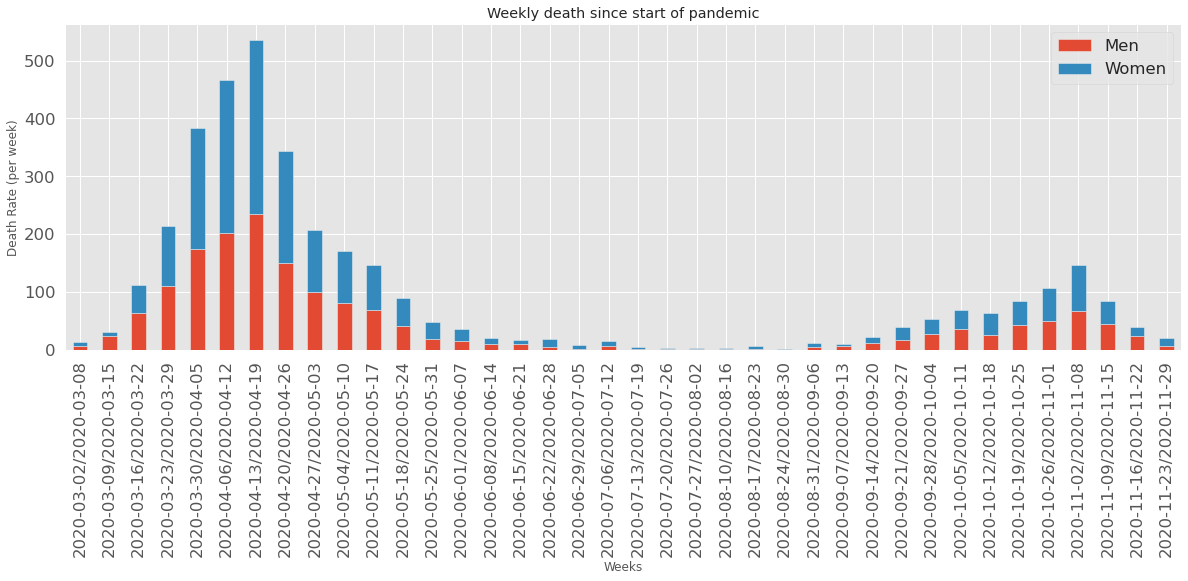

In [8]:
per = df_covid.Accurate_Episode_Date.dt.to_period("W")  # new way to get the same
g_weekly_men2 = df_covid[(df_covid['Client_Gender']=='MALE') & (df_covid['Outcome1']=='Fatal')].groupby(per).count()

per = df_covid.Accurate_Episode_Date.dt.to_period("W")  # new way to get the same
g_weekly_women2 = df_covid[(df_covid['Client_Gender']=='FEMALE') & (df_covid['Outcome1']=='Fatal')].groupby(per).count()

plotdata2 = pd.merge(g_weekly_men2['Row_ID'],g_weekly_women2['Row_ID'],on='Accurate_Episode_Date')
plotdata2.rename(columns={'Row_ID_x': 'Men', 'Row_ID_y': 'Women'}, index={'Accurate_Episode_Date': 'Weeks_Since_Pandemic'}, inplace=True)

plotdata2.plot(kind='bar', stacked=True, figsize=(20, 6), rot=90) # rotate the bars by 90 degrees

plt.xlabel('Weeks')
plt.ylabel('Death Rate (per week)')
plt.title('Weekly death since start of pandemic')

plt.show()

Figure 2: Fatality rate on a weekly basis since the start of pandemic

COVID-19 virus was an unprecedented pandemic. Figure 2 shows how the health knowledge of both health personnel and people has improved over time. The fatality rate of the first wave was too high while in the second wave the fatality rate droped by 80% while affection rate increased by 150%, from 4,000 cases per day to apprximately 10,000 cases per day.
Cumulative fatality shows that since the start of pandemic we had more than 3500 cases died. 

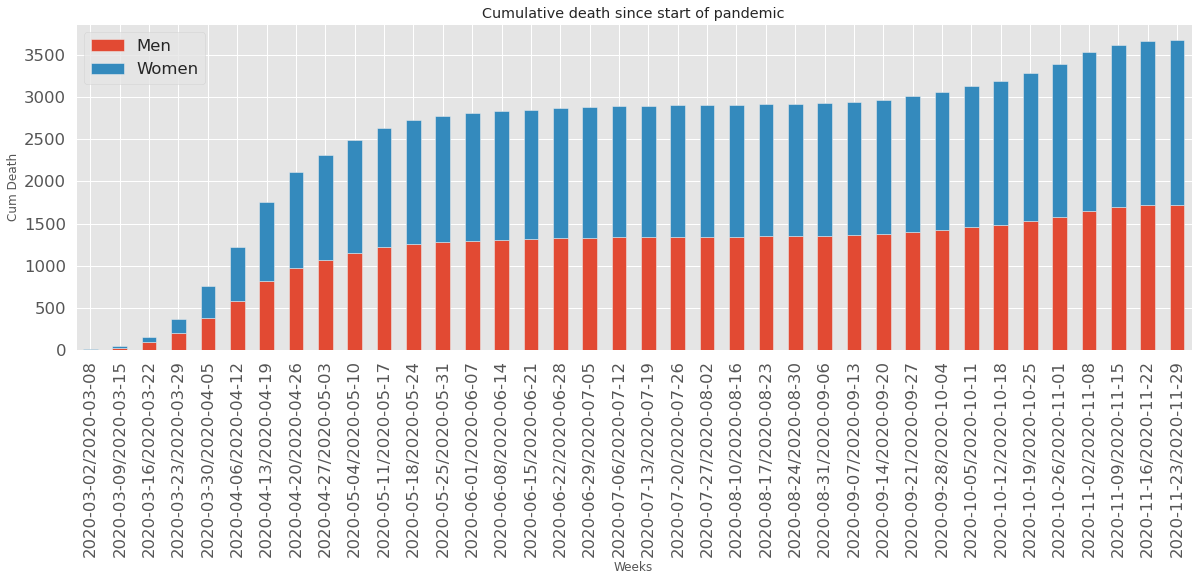

In [9]:
per = df_covid.Accurate_Episode_Date.dt.to_period("W")  # new way to get the same
g_weekly_men3 = df_covid[(df_covid['Client_Gender']=='MALE') & (df_covid['Outcome1']=='Fatal')].groupby(per).count().cumsum()

per = df_covid.Accurate_Episode_Date.dt.to_period("W")  # new way to get the same
g_weekly_women3 = df_covid[(df_covid['Client_Gender']=='FEMALE') & (df_covid['Outcome1']=='Fatal')].groupby(per).count().cumsum()

plotdata3 = pd.merge(g_weekly_men3['Row_ID'],g_weekly_women3['Row_ID'],on='Accurate_Episode_Date')
plotdata3.rename(columns={'Row_ID_x': 'Men', 'Row_ID_y': 'Women'}, index={'Accurate_Episode_Date': 'Weeks_Since_Pandemic'}, inplace=True)

plotdata3.plot(kind='bar', stacked=True, figsize=(20, 6), rot=90) # rotate the bars by 90 degrees

plt.xlabel('Weeks')
plt.ylabel('Cum Death')
plt.title('Cumulative death since start of pandemic')

plt.show()

Figure 3: Cumulative fatality in Ontario Province

Another important measure is the age group of dead people since the start of pandemic. This information is highly demanded to classify and focus on the most vulnerable groups in the society. Figure 4 presents the distribution of fatality by the age group. It shows that seniors must be carefully looked after because the most cases are in the range of 60s and older. Another observation is that as age goes higher, the ratio of female to male fatality increases.

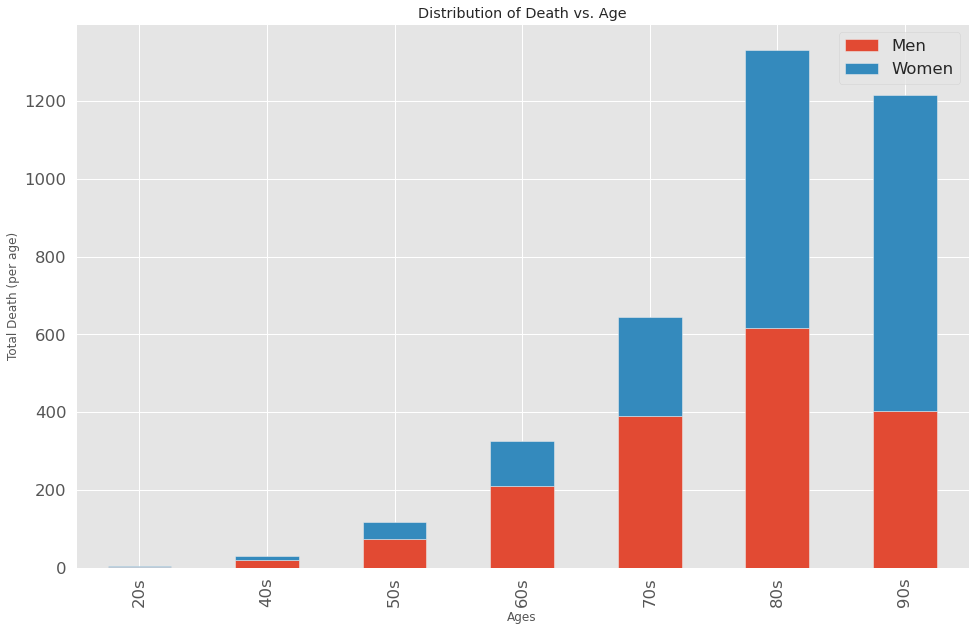

In [10]:
g_weekly_men4 = df_covid[(df_covid['Client_Gender']=='MALE') & (df_covid['Outcome1']=='Fatal')].groupby(df_covid['Age_Group']).count()

g_weekly_women4 = df_covid[(df_covid['Client_Gender']=='FEMALE') & (df_covid['Outcome1']=='Fatal')].groupby(df_covid['Age_Group']).count()

plotdata4 = pd.merge(g_weekly_men4['Row_ID'],g_weekly_women4['Row_ID'],on='Age_Group')
plotdata4.rename(columns={'Row_ID_x': 'Men', 'Row_ID_y': 'Women'}, index={'Age_Group': 'Age_Death'}, inplace=True)

plotdata4.plot(kind='bar', stacked=True, figsize=(16, 10), rot=90) # rotate the bars by 90 degrees

plt.xlabel('Ages')
plt.ylabel('Total Death (per age)')
plt.title('Distribution of Death vs. Age')

plt.show()

Figure 4: Fatality versus the age group

Figure 4 shows the fatality rate decreases for the age range of 90s compared to 80s while this plot does not account for the number of confirmed cases for each 

Text(0.5, 1.0, 'Fataility Percentage vs. Age')

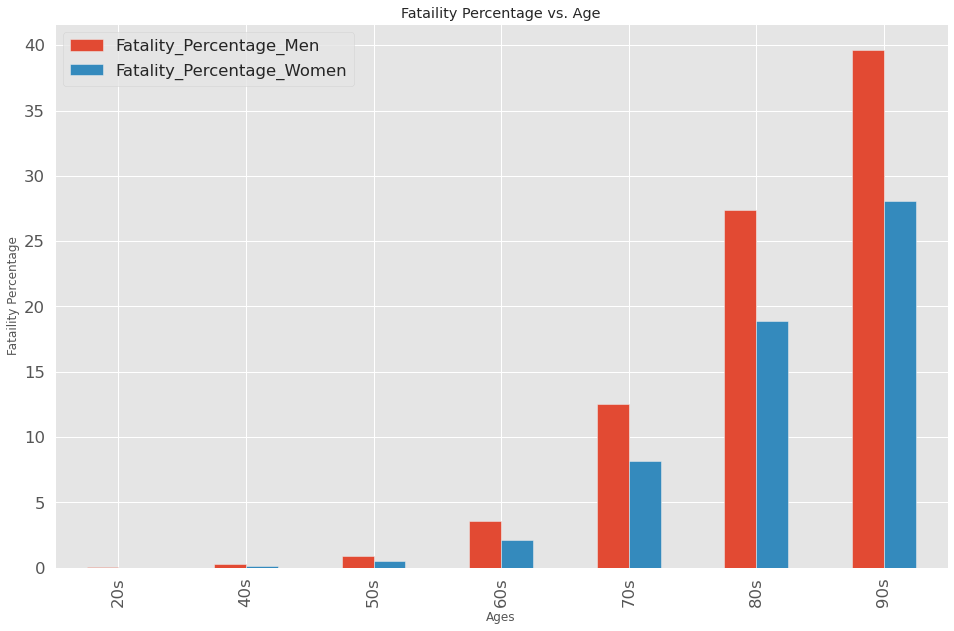

In [11]:
df5=df_covid[['Age_Group','Client_Gender','Outcome1']]
g_weekly_men5 = df5[(df5['Client_Gender']=='MALE') & (df5['Outcome1']=='Fatal')].groupby(df5['Age_Group']).count()
g_weekly_men6 = df5[(df5['Client_Gender']=='MALE')].groupby(df5['Age_Group']).count()
g_weekly_men5['Fatality_Percentage']=g_weekly_men5['Age_Group']*100/g_weekly_men6['Age_Group']
g_weekly_men5.drop(['Age_Group', 'Client_Gender', 'Outcome1'], axis=1, inplace=True)

g_weekly_women5 = df5[(df5['Client_Gender']=='FEMALE') & (df5['Outcome1']=='Fatal')].groupby(df5['Age_Group']).count()
g_weekly_women6 = df5[(df5['Client_Gender']=='FEMALE')].groupby(df5['Age_Group']).count()
g_weekly_women5['Fatality_Percentage']=g_weekly_women5['Age_Group']*100/g_weekly_women6['Age_Group']
g_weekly_women5.drop(['Age_Group', 'Client_Gender', 'Outcome1'], axis=1, inplace=True)

plotdata5 = pd.merge(g_weekly_men5['Fatality_Percentage'],g_weekly_women5['Fatality_Percentage'],on='Age_Group')
plotdata5.rename(columns={'Fatality_Percentage_x': 'Fatality_Percentage_Men', 'Fatality_Percentage_y': 'Fatality_Percentage_Women'}, index={'Age_Group': 'Age_Death'}, inplace=True)

plotdata5.plot(kind='bar', figsize=(16, 10), rot=90) # rotate the bars by 90 degrees

plt.xlabel('Ages')
plt.ylabel('Fataility Percentage')
plt.title('Fataility Percentage vs. Age')

Figure 5: Fatality percentage vs. the age group

Figure 5 shows that the fatality percentage monotonicly increases vs age group and the percentage is lower for women.

## Week 5 - Part D: Map representation of confirmed cases

Number of cases are summed up for each PHU.

Table 3: Number of total confirmed cases by each PHU

In [12]:
df_covid_count = pd.DataFrame(df_covid.groupby(['Reporting_PHU'])['Row_ID'].count())
df_covid_count = df_covid_count.reset_index()
df_covid_count.head()

,Reporting_PHU,Row_ID
0,Algoma Public Health Unit,61
1,Brant County Health Unit,613
2,Chatham-Kent Health Unit,515
3,Durham Region Health Department,4692
4,Eastern Ontario Health Unit,872


The location of each PHU and the total percentage are added to each PHU row in Table 4 and are shown in Figure 6.

Table 4: Location and address of each PHU

In [13]:
df_covid_loc = pd.DataFrame(df_covid.groupby(['Reporting_PHU','Reporting_PHU_Postal_Code'],as_index=True).mean())
df_covid_loc = df_covid_loc.reset_index()
df_covid_loc.drop(['Row_ID'], axis=1, inplace=True)
df_covid_final=pd.merge(df_covid_count,df_covid_loc)
df_covid_final['Percentage_Cases']=df_covid_final['Row_ID']*100/df_covid_final['Row_ID'].sum()
df_covid_final.head()

,Reporting_PHU,Row_ID,Reporting_PHU_Postal_Code,Reporting_PHU_Latitude,Reporting_PHU_Longitude,Percentage_Cases
0,Algoma Public Health Unit,61,P6B 0A9,46.532373,-84.314836,0.050110
1,Brant County Health Unit,613,N3R 1G7,43.151811,-80.274374,0.503561
2,Chatham-Kent Health Unit,515,N7M 5L8,42.403861,-82.208561,0.423057
3,Durham Region Health Department,4692,L1N 0B2,43.898605,-78.940341,3.854337
4,Eastern Ontario Health Unit,872,K6J 5T1,45.029152,-74.736298,0.716322


In [14]:
address = 'Sudbury, ON'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Sudbury is {}, {}.'.format(latitude, longitude))

# create map of Toronto using latitude and longitude values
map_Ontario = folium.Map(location=[latitude, longitude], zoom_start=6)

# add markers to map
for lat, lng, hospital, postalcode, cases in zip(df_covid_final['Reporting_PHU_Latitude'], df_covid_final['Reporting_PHU_Longitude'], df_covid_final['Reporting_PHU'], df_covid_final['Reporting_PHU_Postal_Code'], df_covid_final['Percentage_Cases']):
    label = '{}, {}'.format(postalcode, hospital)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=cases,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Ontario)  
    
map_Ontario

The geograpical coordinate of Sudbury is 46.49272, -80.991211.


In [15]:
map_Ontario.save('HTMMLL.html')

Figure 6: PHUs on map. The blue circles represents the percentage of the confirmed cases (cannot be shown)

## Week 5 - Part E: Finding nearby venues
### Define Foursquare Credentials and Version

The credentials of the app created in FourSquare is given here:

In [16]:
CLIENT_ID = '5CI5CO1LEUXWI12VXCOO1O0UUHPD5RHARRWPV02DQULDLVNM' # your Foursquare ID
CLIENT_SECRET = '0NCZVFFNU3WGX0VVX4UXFBSSKSUKVEYJWG1ZB22LO3SQO4MK' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

#print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

CLIENT_ID: 5CI5CO1LEUXWI12VXCOO1O0UUHPD5RHARRWPV02DQULDLVNM
CLIENT_SECRET:0NCZVFFNU3WGX0VVX4UXFBSSKSUKVEYJWG1ZB22LO3SQO4MK


### Nearby Venues

In [17]:
def getNearbyVenues(names, latitudes, longitudes, radius=3000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Reporting_PHU', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Nearby venues are extraced for the following PHUs:

In [18]:
# type your answer here
Ontario_venues = getNearbyVenues(names = df_covid_final['Reporting_PHU'],
                                   latitudes = df_covid_final['Reporting_PHU_Latitude'],
                                   longitudes = df_covid_final['Reporting_PHU_Longitude']
                                 )


Algoma Public Health Unit
Brant County Health Unit
Chatham-Kent Health Unit
Durham Region Health Department
Eastern Ontario Health Unit
Grey Bruce Health Unit
Haldimand-Norfolk Health Unit
Haliburton, Kawartha, Pine Ridge District Health Unit
Halton Region Health Department
Hamilton Public Health Services
Hastings and Prince Edward Counties Health Unit
Huron Perth District Health Unit
Kingston, Frontenac and Lennox & Addington Public Health
Lambton Public Health
Leeds, Grenville and Lanark District Health Unit
Middlesex-London Health Unit
Niagara Region Public Health Department
North Bay Parry Sound District Health Unit
Northwestern Health Unit
Ottawa Public Health
Peel Public Health
Peterborough Public Health
Porcupine Health Unit
Region of Waterloo, Public Health
Renfrew County and District Health Unit
Simcoe Muskoka District Health Unit
Southwestern Public Health
Sudbury & District Health Unit
Thunder Bay District Health Unit
Timiskaming Health Unit
Toronto Public Health
Wellington-

In [19]:
print('where, they are {} different venues'.format(Ontario_venues.shape[0]))

where, they are 2355 different venues


Venues are inserted into a dataframe where the top five cases are:

Table 5: List of Venues

In [20]:
Ontario_venues.head()

,Reporting_PHU,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Algoma Public Health Unit,46.532373,-84.314836,Shogun Sushi,46.530801,-84.319091,Sushi Restaurant
1,Algoma Public Health Unit,46.532373,-84.314836,Burger Don,46.522580,-84.319638,Burger Joint
2,Algoma Public Health Unit,46.532373,-84.314836,Fratellis,46.542842,-84.318774,Italian Restaurant
3,Algoma Public Health Unit,46.532373,-84.314836,YMCA,46.521494,-84.316275,Gym / Fitness Center
4,Algoma Public Health Unit,46.532373,-84.314836,North 82,46.527674,-84.319183,Steakhouse


## Week 5 - Part F: Neighborhood Venues vs Confirmed Cases in Ontario

In this section, number of confirmed cases is related to the number of venues in the surrounding counties. Figure 7 shows that there is a positive relation between confirmed cases and the number of venues in close proximity. The correlativity increases when we plot confirmed cases per venue. 

In [21]:
Ontario_venues2 = pd.DataFrame(Ontario_venues.groupby('Reporting_PHU').count())
df_covid_venues = pd.merge(df_covid_final,Ontario_venues2[['Venue Category']],on='Reporting_PHU')

df_covid_venues['Confirmed_Cases_per_Venue'] = df_covid_venues['Row_ID']/df_covid_venues['Venue Category']

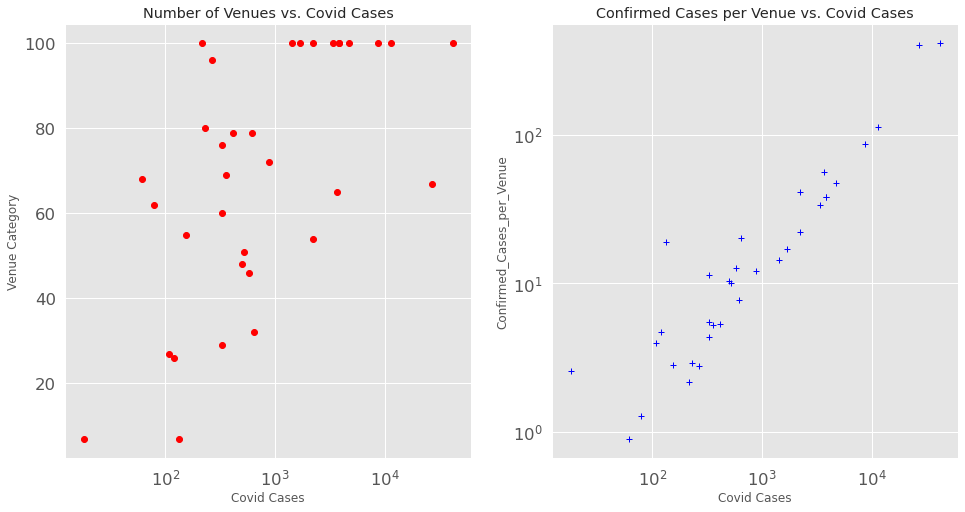

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [1, 1]})
fig.set_size_inches(16, 8)
ax1.plot(df_covid_venues['Row_ID'],df_covid_venues['Venue Category'],'o',color='red')
#axs[0].xscale("log")
ax1.set_title('Number of Venues vs. Covid Cases')
ax1.set(ylabel='Venue Category')
ax1.set(xlabel='Covid Cases')
ax1.set_xscale('log')
#ax1.change_geometry(6,1,3)

ax2.plot(df_covid_venues['Row_ID'],df_covid_venues['Confirmed_Cases_per_Venue'],'+',color='blue')
ax2.set_title('Confirmed Cases per Venue vs. Covid Cases')
ax2.set(ylabel='Confirmed_Cases_per_Venue')
ax2.set(xlabel='Covid Cases')
ax2.set_xscale('log')
ax2.set_yscale('log')
#ax2.change_geometry(1,100,1)

Figure 7: a) Number of venues vs. number of confirmed cases, and b) Confirmed cases per venue vs Confirmed cases in the close neighborhoud

## Week 5 - Part G: Clustering the neighborhouds based on confirmed cases

The regions are clustered in 5 different zones to impose additional restrictions. "KMeans" function is used to cluster the venues based on the confirmed cases per venue.

In [23]:
# set number of clusters
kclusters = 5

#Ontario_grouped_clustering = df_covid_venues[['Row_ID','Venue Category']]
Ontario_grouped_clustering = df_covid_venues[['Venue Category','Confirmed_Cases_per_Venue']]

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Ontario_grouped_clustering)

# check cluster labels generated for each row in the dataframe
#kmeans.labels_

In [24]:
# add clustering labels
df_covid_venues.insert(0, 'Cluster Labels', kmeans.labels_)

#df_covid_venues.head()

In [25]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=6)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_covid_venues['Reporting_PHU_Latitude'], df_covid_venues['Reporting_PHU_Longitude'], df_covid_venues['Reporting_PHU'], df_covid_venues['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Figure 8: Ontario map including clusters (cannot be shown)

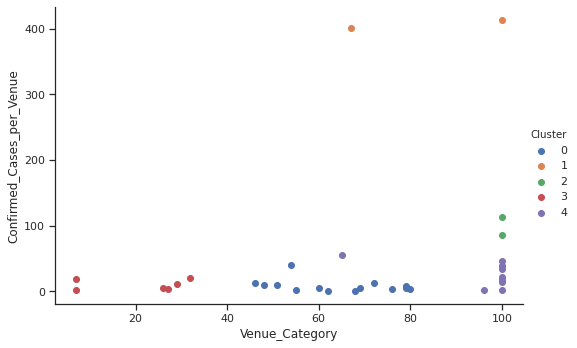

In [26]:
import numpy 
import pandas
from  matplotlib import pyplot
import seaborn
seaborn.set(style='ticks')

numpy.random.seed(0)
N = 34
_clusters= [0, 1, 2, 3, 4]
df = pandas.DataFrame({
    'Venue_Category': df_covid_venues['Venue Category'],
    'Confirmed_Cases_per_Venue': df_covid_venues['Confirmed_Cases_per_Venue'],
    'Cluster': df_covid_venues['Cluster Labels']
})

fg = seaborn.FacetGrid(data=df, hue='Cluster', hue_order=_clusters, height=5, aspect=1.5)
fg.map(pyplot.scatter, 'Venue_Category', 'Confirmed_Cases_per_Venue').add_legend()


Figure 9: Confirmed cases per venue showing different clusters

## Week 5 - Part H: Discussion and Conclusions
Results show that we can manage cities for the next phase of restrictions based on findings of this analysis. Cluster map reveals that Toronto Downtown and Brampton region are associated with the highest level of risk which implies imposing most restrictions. Northern Toronto (newmarket region) and Ontario could be dealt similarly as the second level of risks. Detroit, London, Hamilton and some other same-size cities are in the third category. Smaller cities such as Sudbury are in the next level of decision making. And finally, the lowest risk zones can be defined as Timmins and Simcoe.